### Glucose Prediction Algorithm 

#### Goal: 
Design an algorithm that can predict the glucose levels 30 minutes into the future. Evaluate the model and write a report on findings
#### Data: 
The data is HDeviceCGM from the publicly available dataset on the website: https://public.jaeb.org/t1dx/stdy for “A
Randomized Trial Comparing Continuous Glucose Monitoring With and Without Routine
Blood Glucose Monitoring in Adults with Type 1 Diabetes”. It is the glucose CGM dat for about 250 Dexcomm CGM users over the period of 6 months. The data will be further analyzed below to get needed insights 
#### Steps followed: 
This Project will start with loading the data and getting the packages needed to implement an algorithm. The rest of the step (aka project lifecycle) are as follow:
* Data Preperation 
* Data Analytics 
* Model Generation 
* Model Evaluation 
* Model Deployment 


#### Overview
With the CGM data that is recorded every 5 minutes, it is easy to deduct that it will be a ***Time Series Problem***. ARIMA models will be considered to generate the best fit model. The data contains the glucose value along with a date integer and time of reading. After initial data preperation like datetime standardization and imputation, the data was analyzed. With the help of autocorrelation and partial autocorrelation plots, the best model was determined as AR(50) with a R_Sqaured of 65%. The insights and conclusion are captured at the end of the document 

In [1]:
#loading necessary packages
from dateutil.parser import parse 
import numpy as np
import pandas as pd
from datetime import date, time, datetime, timedelta 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
#reading the file 
df_o = pd.read_csv(r"C:\Users\skyli\Downloads\Protocol_H\Data Tables\HDeviceCGM.txt",sep='|',skiprows=(0),header=(0))

In [3]:
df_o.head()

RecID  ParentHDeviceUploadsID  PtID  SiteID  DeviceDtTmDaysFromEnroll  \
0  1655236                     782   183      12                        -6   
1  1655237                     782   183      12                        -6   
2  1655238                     782   183      12                        -6   
3  1655239                     782   183      12                        -6   
4  1655240                     782   183      12                        -6   

   DeviceTm  DexInternalDtTmDaysFromEnroll DexInternalTm RecordType  \
0  05:35:41                           -6.0      12:37:02        CGM   
1  05:30:41                           -6.0      12:32:02        CGM   
2  05:25:41                           -6.0      12:27:02        CGM   
3  05:20:41                           -6.0      12:22:02        CGM   
4  05:15:41                           -6.0      12:17:02        CGM   

   GlucoseValue  
0         162.0  
1         164.0  
2         168.0  
3         169.0  
4         170.0

In [4]:
df_o.describe().transpose()

count          mean           std    min  \
RecID                          14950661.0  7.616951e+06  4.447060e+06    1.0   
ParentHDeviceUploadsID         14950661.0  5.784978e+03  3.168884e+03    4.0   
PtID                           14950661.0  1.477633e+02  8.531525e+01    2.0   
SiteID                         14950661.0  8.276100e+00  4.412503e+00    1.0   
DeviceDtTmDaysFromEnroll       14950661.0  1.070591e+02  8.177121e+01 -603.0   
DexInternalDtTmDaysFromEnroll  14357889.0  9.752153e+01  1.007653e+02 -456.0   
GlucoseValue                   14950661.0  1.603617e+02  6.467256e+01   25.0   

                                     25%        50%         75%         max  
RecID                          3737666.0  7475331.0  11518213.0  15255878.0  
ParentHDeviceUploadsID            3022.0     5966.0      8652.0     11040.0  
PtID                                72.0      147.0       223.0       293.0  
SiteID                               5.0        8.0        12.0        15.0  
DeviceDtTmDaysFromEnroll            44.0      107.0       172.0       329.0  
DexInternalDtTmDaysFromEnroll       36.0      100.0       169.0       623.0  
GlucoseValue                       112.0      150.0       198.0       600.0

In [5]:
df_o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14950661 entries, 0 to 14950660
Data columns (total 10 columns):
RecID                            int64
ParentHDeviceUploadsID           int64
PtID                             int64
SiteID                           int64
DeviceDtTmDaysFromEnroll         int64
DeviceTm                         object
DexInternalDtTmDaysFromEnroll    float64
DexInternalTm                    object
RecordType                       object
GlucoseValue                     float64
dtypes: float64(2), int64(5), object(3)
memory usage: 1.1+ GB


### Understanding the data 
From the above description of the data, we can see that it is a huge dataset. The column of interest is GlucoseValue and DexInternalDtTmDaysFromEnroll/DeviceDtTmDaysFromEnroll. The columns listed are: 
* RecId - Unique key to identify the row 
* ParentHDeviceUploadsID - Unique Key to indetify the device 
* PtID - Unique Key to indetify the patient
* SiteId - Unknown/ not relevant to this project 
* DeviceDtTmDaysFromEnroll - days from enroll. Can be positive or negative to denote the with or without BG monitoring for the original test case 
* DeviceTm - Time of the reading taken 
* DexInternalDtTmDaysFromEnroll - days from enroll. Can be positive or negative to denote the with or without BG monitoring for the original test case 
* DexInternalTm - Time of the reading in the Dexcom device 
* RecordType - If it is CGM/ BGM                    
* GlucoseValue - The blood glucose value recorded 

The important columns for this project are the glucose value, the date and time of the record. Time series method only uses time as independent variable to forecast the glucose values. While there are other data like doses, meals and other contributing factors to glucose are present in the given dataset, for the purpose of keeping this project simple only glucose value will be considered.  
Let's look at the values of the columns a little deeper.

In [6]:
df_o.RecordType.unique()

array(['CGM', 'Calibration'], dtype=object)

In [7]:
df_o.PtID.nunique()

226

In [8]:
df_o.DeviceDtTmDaysFromEnroll.nunique()

561

The data contains glucose values of 226 users over a span of 561 days max, for every 5 mins of the day. The record can be from CGM or calibration. To develop a time series model only one user with maximum data would be considered as it is a specialized model. Only their CGM data would be considered as well. 

Picking a user at random: 

In [9]:
#Picking ptID 293
df = df_o[df_o['PtID'] == 293]

In [10]:
df.DeviceDtTmDaysFromEnroll.nunique()

247

In [11]:
df.RecordType.unique()

array(['CGM', 'Calibration'], dtype=object)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61037 entries, 13978688 to 14950660
Data columns (total 10 columns):
RecID                            61037 non-null int64
ParentHDeviceUploadsID           61037 non-null int64
PtID                             61037 non-null int64
SiteID                           61037 non-null int64
DeviceDtTmDaysFromEnroll         61037 non-null int64
DeviceTm                         61037 non-null object
DexInternalDtTmDaysFromEnroll    61037 non-null float64
DexInternalTm                    61037 non-null object
RecordType                       61037 non-null object
GlucoseValue                     61037 non-null float64
dtypes: float64(2), int64(5), object(3)
memory usage: 5.1+ MB


This is a more manageable number of rows and becuase it is time-series, we do not have to worry about other columns or getting more information about the dependent variable. 247 days of data is good enough to develop an effective time series model.

Time series forecasting is the use of a model to predict future values based on previously observed values.

### Data Exploration 
Before creating the model, it is important to look deep into the data. Before we start with that, let's shortlist to the records that are only from the CGM and keep only the necessary columns 

In [13]:
#getting CGM values only and keeping the glucose value, date and time 
df = df[df['RecordType'] == 'CGM']
df = df[['DexInternalDtTmDaysFromEnroll','DexInternalTm','GlucoseValue']]

In [14]:
#Sampling the data
df.head()

DexInternalDtTmDaysFromEnroll DexInternalTm  GlucoseValue
13978688                          189.0      08:19:10         280.0
13978689                          189.0      08:14:10         280.0
13978690                          189.0      08:09:10         279.0
13978691                          189.0      08:04:10         279.0
13978692                          189.0      07:59:10         280.0

#### Dealing with the date and time fields 
* Usually, date and time are in a single column. Because this is a study, to keep the anonimity, the dates are changed to integer values. Let's fix that by creating a dummy date 
* The dummy date '2020-01-01' would be assigned to the DexInternalDtTmDaysFromEnroll column for value 1 and the other dates would be extrapolated based on the integer value 
* Date and time can be merged into a single column 

In [15]:
#create function to assign date to DexInternalDtTmDaysFromEnroll and come the time with date 
def create_datetime(row): 
    #function final date that takes each row as an argument 
    #It takes the day and time columns 
    #adds the day to the default date to get the date for the row as row_date
    #returns a value that combines the row_date and the time of the reading 
    day = row['DexInternalDtTmDaysFromEnroll']
    time = row['DexInternalTm']
    default_date = pd.to_datetime('2020-01-01')
    row_date = default_date + timedelta(days=day)  
    return datetime.combine(row_date,datetime.time(pd.to_datetime(time)))
# the function create_datetime is called to get the integrated date and time for the record  


In [16]:
df['datetime'] = df.apply(create_datetime, axis = 1)
df.head()

DexInternalDtTmDaysFromEnroll DexInternalTm  GlucoseValue  \
13978688                          189.0      08:19:10         280.0   
13978689                          189.0      08:14:10         280.0   
13978690                          189.0      08:09:10         279.0   
13978691                          189.0      08:04:10         279.0   
13978692                          189.0      07:59:10         280.0   

                    datetime  
13978688 2020-07-08 08:19:10  
13978689 2020-07-08 08:14:10  
13978690 2020-07-08 08:09:10  
13978691 2020-07-08 08:04:10  
13978692 2020-07-08 07:59:10

In [17]:
#Sorting the values by the datetime column 
df = df.sort_values(by='datetime').reset_index()
df = df[['datetime','GlucoseValue']]

C:\Python\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


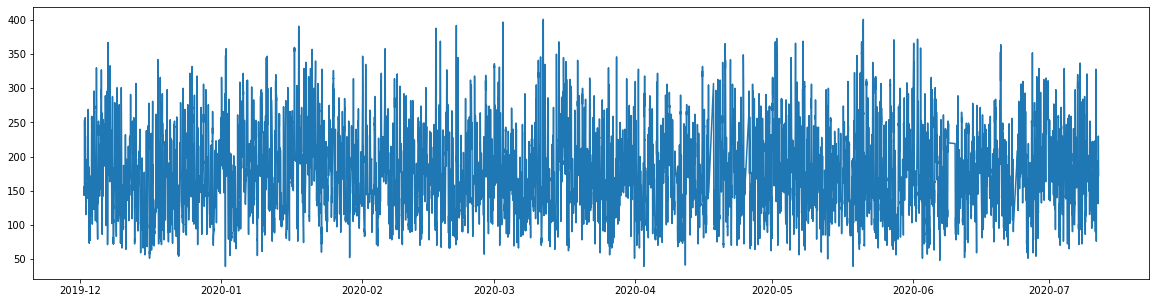

In [18]:
#Plotting the entire time series data
plt.figure(figsize=(20,5))
plt.plot(df.datetime, df.GlucoseValue)

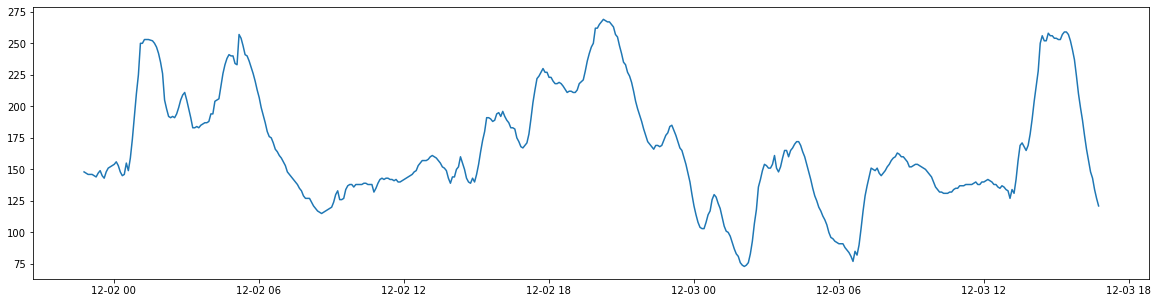

In [19]:
# Taking a closer look at the distribution of data 
plt.figure(figsize=(20,5))
plt.plot(df[:500].datetime, df[:500].GlucoseValue)

In [20]:
df.describe()

GlucoseValue
count  60450.000000
mean     176.568553
std       58.191765
min       39.000000
25%      132.000000
50%      172.000000
75%      215.000000
max      401.000000

### Glucose Levels

Before proceeding further, it is important to understand the glucose levels and look for outliers in the data. 
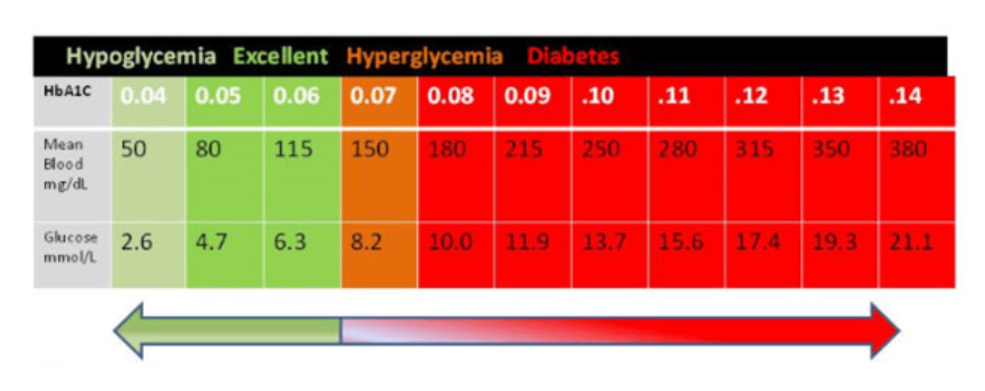
Looks like the the user is mostly between the levels of 132 and 215 with a min of 39 and max of 401. All are possible values of a diabetes patients. Hence it will be concluded that there are no outliers. 

In [21]:
df.head()

datetime  GlucoseValue
0 2019-12-01 22:45:42         148.0
1 2019-12-01 22:50:42         147.0
2 2019-12-01 22:55:42         146.0
3 2019-12-01 23:00:42         146.0
4 2019-12-01 23:05:42         146.0

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60450 entries, 0 to 60449
Data columns (total 2 columns):
datetime        60450 non-null datetime64[ns]
GlucoseValue    60450 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 944.7 KB


### Missing Values 

From the above description, we can see that the there is no NULL values that we need to impute. However with time series data, the missing values can be in the form of entire rows missing. Usually with removable CGM devices, a few minutes/hours of data can be missing due to lost data/removal of device in the interim time. We need to find how many of those missing values might be in the dataset. 

If the CGM device transmits data every 5 mins, a patient should have 288 datapoints per day. Let's check how much data might be missing.

In [23]:
df['dates'] = df['datetime'].dt.date

In [24]:
decipher_GP = df.groupby('dates').count().reset_index()
decipher_GP.head()

dates  datetime  GlucoseValue
0  2019-12-01        15            15
1  2019-12-02       284           284
2  2019-12-03       285           285
3  2019-12-04       283           283
4  2019-12-05       247           247

In [25]:
fig = px.box(decipher_GP, y="GlucoseValue")
fig.show()

In [26]:
decipher_GP[decipher_GP['GlucoseValue'] < 255]

dates  datetime  GlucoseValue
0    2019-12-01        15            15
4    2019-12-05       247           247
31   2020-01-01       233           233
52   2020-01-22       251           251
56   2020-01-26       249           249
59   2020-01-29       251           251
66   2020-02-05       231           231
74   2020-02-13       253           253
81   2020-02-20       253           253
88   2020-02-27       216           216
95   2020-03-05       252           252
103  2020-03-13       247           247
116  2020-03-26       157           157
123  2020-04-02       233           233
130  2020-04-09       203           203
131  2020-04-10       221           221
138  2020-04-17        42            42
139  2020-04-18       232           232
146  2020-04-25        35            35
153  2020-05-02       254           254
169  2020-05-18       232           232
176  2020-05-25       222           222
183  2020-06-01       235           235
190  2020-06-08       242           242
191  2020-06-10       212           212
197  2020-06-16       232           232
204  2020-06-23        30            30
218  2020-07-07       254           254
222  2020-07-11       226           226

This is tricky because as a time-series data, we want continuation and hence we cannot simply drop the dates with few data points. Hence coming up with a way to handle this is crucial to continue with the modelling. 

To check that, a dummy dataframe with datetime for every 5 mins from the range of min datetime and max datetime present for this user. This will contain the datetime that might be missing in our dataframe. By comparing the data to this dummy dataframe, we can relate to the missing data points directly. 

In [27]:
#Getting the closest records from the df based on the datetime field 
def get_closest(n):
    #Function that gets the row from dates 
    #Finds the first row that is the closest in the df
    #if it spots the values, it checks if the difference is within 300 seconds(5 mins)
    #if it is, it returns the value, else returns Nulls
    mask = df['datetime'] >= n
    ids = np.where(mask)[0]
    if ids.size > 0:
        difference = df.datetime[ids[0]] - n 
        if difference.seconds <= 300:
            GV = df.GlucoseValue[ids[0]]
        else:
            GV = np.nan
#         seconds_in_day = 24 * 60 * 60
#         if difference 
        return ids[0], GV
#         return ids[0], df.GlucoseValue[ids[0]]
    else:
        return np.nan,np.nan

In [28]:
dates = pd.DataFrame({'date': pd.date_range(df['datetime'].min(), df['datetime'].max(), freq='5min')})

In [29]:
dates.loc[16888,'date']

Timestamp('2020-01-29 14:05:42')

In [30]:
answer = get_closest(dates.loc[16888,'date'])
print(answer)

(16235, 196.0)


In [31]:
df.loc[16235]

datetime        2020-01-29 14:06:18
GlucoseValue                    196
dates                    2020-01-29
Name: 16235, dtype: object

In [32]:
#Ordering the data to fit the new dataframe.
def ordered_data(df):
    #Function to get the closest glucose values to the time. Since it is in 5 min intervals there will not be any datetime that will have 2 values 
    #A new dataframe values is created along with an ordered datetime dataframe called dates 
    #For each value of dates the closest glucose value is assigned from the above function 
    #A new dataframe is returned that is ordered cronologically 
    values = pd.DataFrame()
    dates = pd.DataFrame({'date': pd.date_range(df['datetime'].min(), df['datetime'].max(), freq='5min')})
    for date in dates.date:
        try:
            index, glucose_value = get_closest(date)
        except:
            print(date)
            break
        temp = pd.DataFrame({'date':[date],'GlucoseValue':[glucose_value]})
        values = values.append(temp, ignore_index = True)          
    return values

In [33]:
formatted_df = ordered_data(df)

In [34]:
formatted_df['date'] = pd.to_datetime(formatted_df['date'])

In [35]:
formatted_df.head()

date  GlucoseValue
0 2019-12-01 22:45:42         148.0
1 2019-12-01 22:50:42         147.0
2 2019-12-01 22:55:42         146.0
3 2019-12-01 23:00:42         146.0
4 2019-12-01 23:05:42         146.0

In [36]:
temp = formatted_df.groupby('date').count().reset_index()
temp[temp['GlucoseValue']> 1]

Empty DataFrame
Columns: [date, GlucoseValue]
Index: []

Each row in the formatted_df is 5 mins apart and each row has only one glucose value assigned. Now let's look at the data to see how the ordering of the data has worked - A sample

In [37]:
#Sample of missing values in date that is filled with NaN
formatted_df.loc[41745:41758]

date  GlucoseValue
41745 2020-04-24 21:30:42          76.0
41746 2020-04-24 21:35:42           NaN
41747 2020-04-24 21:40:42           NaN
41748 2020-04-24 21:45:42          93.0
41749 2020-04-24 21:50:42          98.0
41750 2020-04-24 21:55:42           NaN
41751 2020-04-24 22:00:42         103.0
41752 2020-04-24 22:05:42         111.0
41753 2020-04-24 22:10:42         117.0
41754 2020-04-24 22:15:42         120.0
41755 2020-04-24 22:20:42         125.0
41756 2020-04-24 22:25:42         132.0
41757 2020-04-24 22:30:42           NaN
41758 2020-04-24 22:35:42         142.0

In [38]:
#Original data for reference
df.loc[39582:39592]

datetime  GlucoseValue       dates
39582 2020-04-24 21:34:34          76.0  2020-04-24
39583 2020-04-24 21:49:34          93.0  2020-04-24
39584 2020-04-24 21:54:34          98.0  2020-04-24
39585 2020-04-24 22:04:34         103.0  2020-04-24
39586 2020-04-24 22:09:34         111.0  2020-04-24
39587 2020-04-24 22:14:35         117.0  2020-04-24
39588 2020-04-24 22:19:34         120.0  2020-04-24
39589 2020-04-24 22:24:35         125.0  2020-04-24
39590 2020-04-24 22:29:34         132.0  2020-04-24
39591 2020-04-24 22:39:34         142.0  2020-04-24
39592 2020-04-24 22:44:34         143.0  2020-04-24

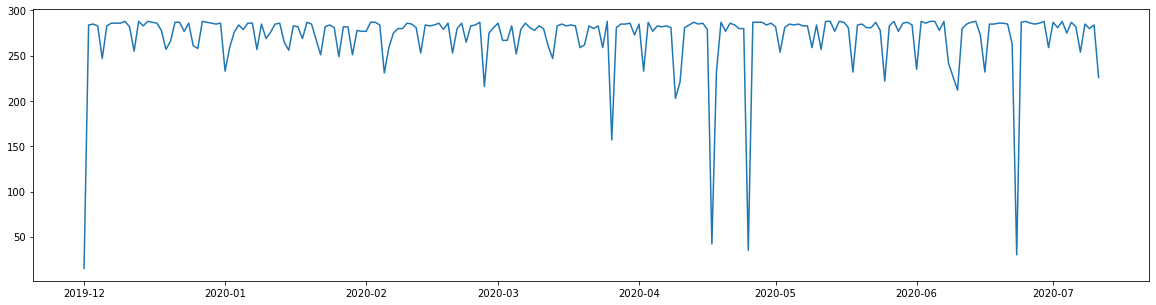

In [39]:
#Measuring how much data is missing for each day 
plt.figure(figsize=(20,5))
plt.plot(decipher_GP.dates, decipher_GP.GlucoseValue)

We can see that there are a lot of losses on the dates after 2020-04-16. We will look into the best way to extrapolate the data.

In [40]:
#Sample data of continuous missing time 
formatted_df.loc[41800:41810]

date  GlucoseValue
41800 2020-04-25 02:05:42         147.0
41801 2020-04-25 02:10:42         151.0
41802 2020-04-25 02:15:42         154.0
41803 2020-04-25 02:20:42           NaN
41804 2020-04-25 02:25:42           NaN
41805 2020-04-25 02:30:42           NaN
41806 2020-04-25 02:35:42           NaN
41807 2020-04-25 02:40:42           NaN
41808 2020-04-25 02:45:42           NaN
41809 2020-04-25 02:50:42           NaN
41810 2020-04-25 02:55:42           NaN

### Interpolating the data
Since we have a few days with about 38 readings (38/288 - ~15%), we will explore ways to interpolate the data. A comparison will be made between the different methods to choose the closest 

In [41]:
impute_data = formatted_df 
impute_data = impute_data.assign(InterpolateLinear=impute_data.GlucoseValue.interpolate(method='linear'))
impute_data.loc[41800:41810]

date  GlucoseValue  InterpolateLinear
41800 2020-04-25 02:05:42         147.0         147.000000
41801 2020-04-25 02:10:42         151.0         151.000000
41802 2020-04-25 02:15:42         154.0         154.000000
41803 2020-04-25 02:20:42           NaN         154.434263
41804 2020-04-25 02:25:42           NaN         154.868526
41805 2020-04-25 02:30:42           NaN         155.302789
41806 2020-04-25 02:35:42           NaN         155.737052
41807 2020-04-25 02:40:42           NaN         156.171315
41808 2020-04-25 02:45:42           NaN         156.605578
41809 2020-04-25 02:50:42           NaN         157.039841
41810 2020-04-25 02:55:42           NaN         157.474104

#### A sample plot of how the inerpolation handles missing data 

In [92]:
#plot of original data
fig = px.line(formatted_df.loc[42100:42900], x='date', y="GlucoseValue")
fig.show()

In [42]:
#plot of original data
fig = px.line(formatted_df.loc[41800:42100], x='date', y="GlucoseValue")
fig.show()

In [43]:
#plot of interpolated data
fig = px.line(impute_data.loc[41800:42100], x='date', y="InterpolateLinear")
fig.show()

### Checking a few more Interpolation Technique
Time interpolation and quadriatic interpolation might be good options. To do that the index has to be of type datetime. We will do the changes and assess the results of the interpolation 

In [44]:
#setting index to the datetime of the reading 
impute_data = impute_data.set_index('date')
impute_data.index

DatetimeIndex(['2019-12-01 22:45:42', '2019-12-01 22:50:42',
               '2019-12-01 22:55:42', '2019-12-01 23:00:42',
               '2019-12-01 23:05:42', '2019-12-01 23:10:42',
               '2019-12-01 23:15:42', '2019-12-01 23:20:42',
               '2019-12-01 23:25:42', '2019-12-01 23:30:42',
               ...
               '2020-07-11 18:05:42', '2020-07-11 18:10:42',
               '2020-07-11 18:15:42', '2020-07-11 18:20:42',
               '2020-07-11 18:25:42', '2020-07-11 18:30:42',
               '2020-07-11 18:35:42', '2020-07-11 18:40:42',
               '2020-07-11 18:45:42', '2020-07-11 18:50:42'],
              dtype='datetime64[ns]', name='date', length=64178, freq=None)

In [45]:
#Computing various interpolations
impute_data = impute_data.assign(InterpolateLinear=impute_data.GlucoseValue.interpolate(method='linear'))
impute_data = impute_data.assign(InterpolateTime=impute_data.GlucoseValue.interpolate(method='time'))
impute_data = impute_data.assign(InterpolateQuadratic=impute_data.GlucoseValue.interpolate(method='quadratic'))
impute_data = impute_data.assign(InterpolateSLinear=impute_data.GlucoseValue.interpolate(method='slinear'))
impute_data = impute_data.assign(InterpolateAkima=impute_data.GlucoseValue.interpolate(method='akima'))

In [46]:
#resetting index to integer indexing 
impute_data = impute_data.reset_index()

In [47]:
#plotting the 4 interpolation methods to assess how they handle missing data
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Time", "Quadriatic", "SLinear", "Akima"))

fig.add_trace(go.Scatter(x=impute_data.loc[41800:42100,'date'], y=impute_data.loc[41800:42100,"InterpolateTime"]),
              row=1, col=1)

fig.add_trace(go.Scatter(x=impute_data.loc[41800:42100,'date'], y=impute_data.loc[41800:42100,"InterpolateQuadratic"]),
              row=1, col=2)

fig.add_trace(go.Scatter(x=impute_data.loc[41800:42100,'date'], y=impute_data.loc[41800:42100,"InterpolateSLinear"]),
              row=2, col=1)

fig.add_trace(go.Scatter(x=impute_data.loc[41800:42100,'date'], y=impute_data.loc[41800:42100,"InterpolateAkima"]),
              row=2, col=2)

fig.show()

Looking at these plots, the quadriatic plot, though dispersed over time can mimic the glucose ups and downs. Let's use the values from this interpolation method to update the missing values in glucose 

In [48]:
# taking InterpolateQuadratic as the final Glucose Value
impute_data = impute_data[['date','InterpolateQuadratic']]
impute_data.rename(columns={'InterpolateQuadratic':'GlucoseValue'}, inplace=True)
impute_data.head()

date  GlucoseValue
0 2019-12-01 22:45:42         148.0
1 2019-12-01 22:50:42         147.0
2 2019-12-01 22:55:42         146.0
3 2019-12-01 23:00:42         146.0
4 2019-12-01 23:05:42         146.0

In [49]:
#Since this is a univariate analysis, assigning the data to y 
y = impute_data

In [50]:
fig = px.box(y, y="GlucoseValue")
fig.show()

### Univariate Time Series Forecasting.
An ARIMA model is characterized by 3 terms: p, d, q

where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

For our problem, d is 0 as the data is stationary. Let's look at deciphering p and q

### Statistical Inference for Stationarity
The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

In [51]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(y.GlucoseValue.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -18.713710
p-value: 0.000000


### Understanding Seasonality 
A repeat in the pattern of the time series. With glucose 

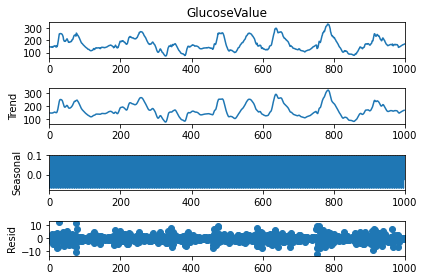

In [52]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(y.loc[:1000].GlucoseValue, model='additive', freq=5)
x = decomposed.plot() #See note below about this

We can observe that there is no seasonality observed in the sample data

### Configuring an Time Series Model 
Now that we have confirmed that there is no seasonality and trend in our data, we don't have to transform our data (log or diff). We will follow the ***Box-Jenkins Method*** to determine the best fit model 
### Modeling approach 
Three stages are present usually in the Modeling: 
1. Model Selection - Using the ACF and PACF to determine the lags for AR and MA parts of the model
1. Parameter Estimation - Finding the coeffecients of the best fit model
1. Statistical Model Check - Checking the residulas to estimate if the model has absorbed enough data to estimate adequately 

If the statistical model check is not satisfactory, the process can be repeacted to find the perfect model. 
Other than this, a few metrics like R-squared and MSE will be used to determine the effectiveness of the predictions 

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### Model Selection 
ACF and PACF 

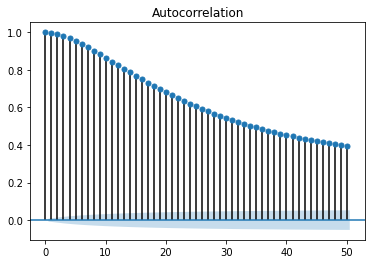

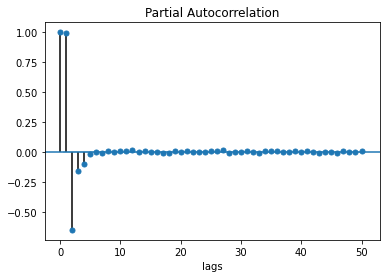

In [54]:
#plotting to check auto correlation and partial auto correlation 
plot_acf(y.GlucoseValue, lags=50)
plot_pacf(y.GlucoseValue, lags=50)
plt.xlabel('lags')
plt.show()

Looking at the graph above, we can see that the ACF follows a geometric decay. We can conclude that there in only AR component is needed to generate the model. 
If we look at the pacf, there are 4 significant peaks. While there is a continued little peaks on the negative side, we will start modelling for ***lag 4***

#### Parameter Estimation

Since there is no Seasonal pattern and MA (Moving average), we will focus on AR model and ARMA model with q value as 0 

In [55]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA

In [56]:
#creating ARMA model with p = 4
X = y.GlucoseValue
data = X[:30000]
model_ARMA = ARMA(data, order=(4, 0))
model_ARMA_fit = model_ARMA.fit()

In [57]:
model_ARMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           GlucoseValue   No. Observations:                30000
Model:                     ARMA(4, 0)   Log Likelihood              -88700.290
Method:                       css-mle   S.D. of innovations              4.654
Date:                Mon, 21 Sep 2020   AIC                         177412.581
Time:                        11:36:24   BIC                         177462.434
Sample:                             0   HQIC                        177428.577
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                175.4361      2.395     73.257      0.000     170.742     180.130
ar.L1.GlucoseValue     1.5028      0.006    261.573      0.000       1.492       1.514
ar.L2.GlucoseValue    -0.4050      0.010    -38.915      0.000      -0.425      -0.385
ar.L3.GlucoseValue    -0.0110      0.010     -1.054      0.292      -0.031       0.009
ar.L4.GlucoseValue    -0.0981      0.006    -17.077      0.000      -0.109      -0.087
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0528           -0.0000j            1.0528           -0.0000
AR.2            1.1880           -0.0000j            1.1880           -0.0000
AR.3           -1.1763           -2.6009j            2.8546           -0.3176
AR.4           -1.1763           +2.6009j            2.8546            0.3176
-----------------------------------------------------------------------------
"""

Looks like all the co-efficients along with the constant is important, based on their p-values except L3. Let's look at the residual plot

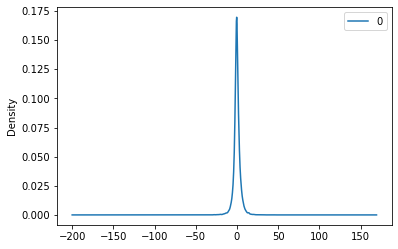

In [58]:
# plot residual errors
residuals = pd.DataFrame(model_ARMA_fit.resid)
residuals.plot(kind='kde')

In [59]:
residuals.describe()

0
count  30000.000000
mean      -0.000436
std        4.656370
min     -107.659947
25%       -1.738182
50%       -0.203674
75%        1.648419
max       77.009344

This suggests that the residuals are centered around zero. This shows that the model is good to fit. Since we have one model, aic may not be a good metric to look at. aic is a great metric to look at when we do Grid Search to find the optimal value of p,d, and q to get the best model 

In [60]:
model_ARMA_fit.aic

177412.58066772154

### Validating Forecasting
Let's look at how it predicts. This will help us understand the accuracy of forecasting. We have fitted the data until 30000 index. We set to forecast the next 6 glucose (the 30 mins mark)

In [61]:
# make prediction
yhat = model_ARMA_fit.predict(len(data), len(data)+5)
print(yhat)

30000    143.150001
30001    146.457521
30002    149.224216
30003    151.659382
30004    153.804066
30005    155.686154
dtype: float64


In [62]:
#The actual values
y.loc[30000:30006].GlucoseValue

30000    143.0
30001    149.0
30002    151.0
30003    155.0
30004    160.0
30005    165.0
30006    170.0
Name: GlucoseValue, dtype: float64

In [63]:
#creating a dataframe to record the predicted and actual values to analyze further 
predictions = pd.DataFrame()
predictions = predictions.append(pd.DataFrame(data={'predicted':yhat,'actual':y.loc[30000:30005,'GlucoseValue']}))   

predictions

predicted  actual
30000  143.150001   143.0
30001  146.457521   149.0
30002  149.224216   151.0
30003  151.659382   155.0
30004  153.804066   160.0
30005  155.686154   165.0

### Metrics for Validation 
As the model is AR(AutoRegression), we can look at the MSE (Mean Squared Error) and R_Sqaured
#### MSE
Thhis is the average sqaured difference between the predictions and the actuals. It can be taken as a measure of the quality of the estimator. The MSE has to be closer to zero
#### R-Sqaured
Also called the coefficient of determination, it is the proportion of the variance in the dependent variable that is predictable from the independent variables. It can be taken as a measure of how well the predictions reflect the actual values. It can range between 0 and 1. Closer to 1 shows effective model 

In [64]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [65]:
error = mean_squared_error(predictions.actual, predictions.predicted)
print('Test MSE: %.3f' % error)
print('R_Squared: %.3f' % r2_score(predictions.actual, predictions.predicted))

Test MSE: 24.323
R_Squared: 0.533


Test MSE is 24.323. This shows that the predictions are effective. It is not backed by R_Sqaured which is 53%. Let's try to see if we can optimize the model.  

### AR model 
Using AR model, we can let the model to choose the optimal lag value. By inplementing this, we can see if the small peaks after the lag 4 is important in assisting with the predictions. 

Here we call the initial 30000 data points as train_dats

In [66]:
#create train/test datasets
X = y.GlucoseValue
train_data = X[:30000]

#train the autoregression model
model = AR(train_data)
model_AR_fitted = model.fit()

In [67]:
#Optimized lag value 
print('The lag value chosen is: %s' % model_AR_fitted.k_ar)

The lag value chosen is: 50


In [68]:
#looking at the co-efficients of the model 
print('The coefficients of the model are:\n %s' % model_AR_fitted.params)

The coefficients of the model are:
 const               2.086108
L1.GlucoseValue     1.497944
L2.GlucoseValue    -0.405302
L3.GlucoseValue    -0.024223
L4.GlucoseValue    -0.059040
L5.GlucoseValue    -0.012005
L6.GlucoseValue     0.004291
L7.GlucoseValue    -0.006896
L8.GlucoseValue     0.000032
L9.GlucoseValue    -0.004397
L10.GlucoseValue   -0.008834
L11.GlucoseValue   -0.003479
L12.GlucoseValue    0.018137
L13.GlucoseValue   -0.023021
L14.GlucoseValue    0.012381
L15.GlucoseValue   -0.001981
L16.GlucoseValue    0.003408
L17.GlucoseValue    0.023491
L18.GlucoseValue   -0.022041
L19.GlucoseValue    0.010360
L20.GlucoseValue   -0.025792
L21.GlucoseValue    0.019332
L22.GlucoseValue   -0.004714
L23.GlucoseValue    0.011624
L24.GlucoseValue   -0.015709
L25.GlucoseValue   -0.010374
L26.GlucoseValue   -0.001559
L27.GlucoseValue    0.023604
L28.GlucoseValue    0.002639
L29.GlucoseValue   -0.002725
L30.GlucoseValue   -0.014449
L31.GlucoseValue    0.008666
L32.GlucoseValue    0.012697
L33.Glu

### Residuals 

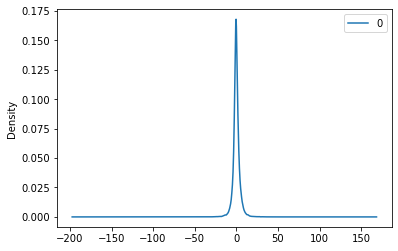

In [69]:
# plot residual errors
residuals = pd.DataFrame(model_AR_fitted.resid)
residuals.plot(kind='kde')

In [70]:
residuals.describe()

0
count  2.995000e+04
mean  -3.769070e-13
std    4.640808e+00
min   -1.058360e+02
25%   -1.738849e+00
50%   -1.958809e-01
75%    1.654533e+00
max    7.701907e+01

The residula plot shows that they are tighter/closer to zero than the previous model. 


Autocorrelation calculates the strength of the relationship between an observation and observations at prior time steps. We can calculate the autocorrelation of the residual error time series and plot the results. We do not see an obvious autocorrelation trend across the plot.

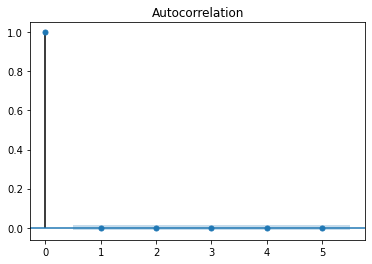

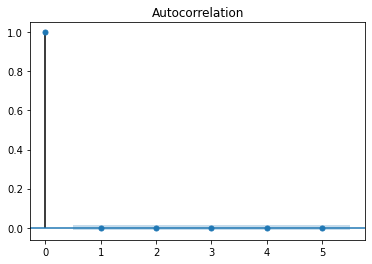

In [71]:
plot_acf(residuals, lags=5)


### Validating Forecasting 

In [79]:
# make predictions 
yhat = model_AR_fitted.predict(
    start=len(train_data), 
    end=len(train_data) + 6, 
    dynamic=False)
predictions = pd.DataFrame()
predictions = predictions.append(pd.DataFrame(data={'predicted':yhat}, index = range(len(train_data),len(train_data)+6)))

# create a comparison dataframe
compare_df = pd.concat(
    [y.loc[len(train_data):len(train_data)+6,'GlucoseValue'],
    predictions], axis=1).rename(
    columns={'stationary': 'actual', 0:'predicted'})

In [80]:
compare_df.head()

GlucoseValue   predicted
30000         143.0  143.274396
30001         149.0  146.748714
30002         151.0  149.660790
30003         155.0  152.406902
30004         160.0  154.668304

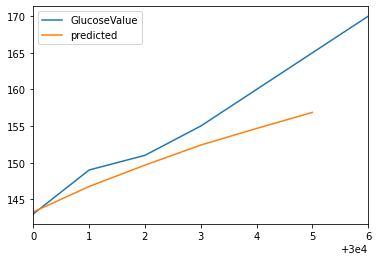

In [81]:
#plot the two values
compare_df.plot()

### Model Evaluation 

Looks like the prediction is very strong at value 1 of prediction. With increase in time (t+1, t+2 and so on), the prediction power decreases. This means that the Confidence Interval is tighter at t and expands at t+6. This is expected with any forecasting. The power of forecasting is high at the first forecast. 

However looking at the MSE and R_sqaured, it is assuring that the model has improved in the prediction power. Overall, our forecasts align well with the actual values in capturing the trend/direction of glucose 

In [82]:
error = mean_squared_error(y.loc[len(train_data):len(train_data)+5,'GlucoseValue'],
    predictions)
print('Sample MSE: %.3f' % error)
print('R_Squared: %.3f' % r2_score(y.loc[len(train_data):len(train_data)+5,'GlucoseValue'],
    predictions))

Sample MSE: 18.040
R_Squared: 0.654


### Rolling Forecast 
Although there can be room for improvement, the AR model performs well with a R_sqaured of 65%. We can use this to forecast the 30 mins of glucose with the incoming data. 
 
Assuming that the user/patient has 30000 datapoints with a new data point/glucose value coming in every 5 mins. The rolling forecast should be able to capture that to tweak the forward forcastings. This will be handled by the algorithm below and a rolling forecast for the next 30 mins will be generated every 5 mins. 

In [119]:
X = y.GlucoseValue
limit = 30000
train = X[:limit]
test = X[limit:]
history = [x for x in train]
predictions = pd.DataFrame()
prediction_values = pd.DataFrame()
for t in range(limit,limit+10):
    #train the autoregression model
    model = AR(history)
    length = len(history)
    model_fit = model.fit()
    # make predictions 
    yhat = model_fit.predict(start = length,
        end=length+6, 
        dynamic=False)
    predictions = predictions.append(pd.DataFrame(data={'predicted':yhat,'actual':y.loc[t:t+6,'GlucoseValue'],'for time': t }))
    prediction_values = prediction_values.append(pd.DataFrame(data={'predicted':yhat[0]}, index=[t]))
    history.append(test[t])
    #Evaluate the model at every step
    print('predicted = %f, expected = %f' % (yhat[0:1][0], y.loc[t].GlucoseValue))
    print('Individual R_Squared: %.3f' % r2_score(y.loc[t:t+6,'GlucoseValue'],yhat))

#Generate overall metrics
error = mean_squared_error(y.loc[limit:limit+9,'GlucoseValue'], prediction_values)
print('Overall MSE: %.3f' % error)
print('Overall R_Squared: %.3f' % r2_score(y.loc[limit:limit+9,'GlucoseValue'], prediction_values))
# create a comparison dataframe
compare_df = pd.concat(
    [y.loc[limit-50:limit+10,'GlucoseValue'],
    prediction_values], axis=1).rename(
    columns={'stationary': 'actual', 0:'predicted'})

predicted = 143.274396, expected = 143.000000
Individual R_Squared: 0.560
predicted = 146.337674, expected = 149.000000
Individual R_Squared: 0.132
predicted = 153.144375, expected = 151.000000
Individual R_Squared: 0.780
predicted = 153.507014, expected = 155.000000
Individual R_Squared: -0.561
predicted = 157.972017, expected = 160.000000
Individual R_Squared: -0.321
predicted = 163.639887, expected = 165.000000
Individual R_Squared: 0.189
predicted = 168.547821, expected = 170.000000
Individual R_Squared: 0.293
predicted = 173.605119, expected = 171.000000
Individual R_Squared: 0.355
predicted = 172.541708, expected = 174.000000
Individual R_Squared: -1.098
predicted = 176.438467, expected = 179.000000
Individual R_Squared: -1.311
Overall MSE: 3.754
Overall R_Squared: 0.971


In [122]:
X = y.GlucoseValue
limit = 30000
train = X[:limit]
test = X[limit:]
history = [x for x in train]
predictions = pd.DataFrame()
prediction_values = pd.DataFrame()
for t in range(limit,limit+100):
    #train the autoregression model
    model = AR(history)
    length = len(history)
    model_fit = model.fit()
    # make predictions 
    yhat = model_fit.predict(start = length,
        end=length+6, 
        dynamic=False)
    predictions = predictions.append(pd.DataFrame(data={'predicted':yhat,'actual':y.loc[t:t+6,'GlucoseValue'],'for time': t }))
    prediction_values = prediction_values.append(pd.DataFrame(data={'predicted':yhat[0]}, index=[t]))
    history.append(test[t])
    #Evaluate the model at every step
    #print('predicted = %f, expected = %f' % (yhat[0:1][0], y.loc[t].GlucoseValue))
    #print('Individual R_Squared: %.3f' % r2_score(y.loc[t:t+6,'GlucoseValue'],yhat))

#Generate overall metrics
error = mean_squared_error(y.loc[limit:limit+9,'GlucoseValue'], prediction_values)
print('Overall MSE: %.3f' % error)
print('Overall R_Squared: %.3f' % r2_score(y.loc[limit:limit+9,'GlucoseValue'], prediction_values))
# create a comparison dataframe
compare_df = pd.concat(
    [y.loc[limit-50:limit+10,'GlucoseValue'],
    prediction_values], axis=1).rename(
    columns={'stationary': 'actual', 0:'predicted'})

ValueError: Found input variables with inconsistent numbers of samples: [10, 100]

### Results Interpretation 
There is a notable fluctuation in the individual forecasts (Individual R_Squared). This can be due to the unforseen conditions. Though time-series models are non-parametric, including other conditions/features will enhance the model to be generated. 

That said, the first prediction/one-step forecasting is quite strong. The overall MSE is 3.75 which is closer to 0 and R-Sqaured is 97%. This can be utilized to recaliberate the algorithm every 5 mins. The plot below shows the significant results of the one-step forecasting 

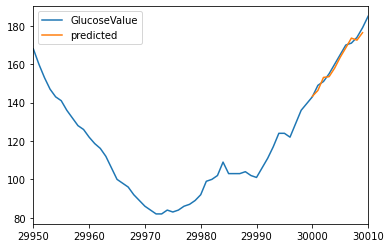

In [120]:
#plot the actuals Vs. predictions
compare_df.plot()

### Conclusion 
Overall 2 models were evaluated in the above code to predict the next 30 mins of glucose reading for a single patient/user. After data preperation, the data was evaluated to find that it needs ***AR model*** implementation. First, a AR model with lag 4 was developed which gave a R-sqaured value of 51%. The second model chose the lag 50 and improved the R-sqaured value by ~15%. Hence this model was chosen to use in further forecasting and prediction. 

While making a rolling forecasting, it was noted that the prediction power of the model(through R-Sqaured Value) fluctuates with every step. While this can be an acceptable criterion in the financial and retail sectors, with health sector the predictions has to be as close as possible to real life. Expecially with the glucose data, it is possible for a user to quickly slip into hypoglycemia. Hence an use case was developed to where the model generated above can be utilized. T

#### Use Case 
With incoming data point at every 5 mins, the AR model will generate the next 30 mins of predictions. This will be overriden at every 5 min interval. The values generated will be a possible prediction and will not be used as an indicator to take any action (doses,food and more). This can be used to understand the direction of glucose, if it is in target blood glucose range or towards below range/ above range. A more robust model is required that will take into consideration the insulin on board, incoming bolus, carb intake, physical activity to include actions to take

This can be visually explained in the plot below. 

In [123]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#Overall Plot 
fig = go.Figure()
to_plot = y.loc[limit-100:limit+100]
for_time_values = [x for x in predictions['for time'].unique()]
fig.add_trace(go.Scatter(x=to_plot.index,
                 y=to_plot.GlucoseValue,
                    mode='lines',
                    name='lines'))
for item in for_time_values:
    fig.add_trace(go.Scatter(x=predictions[predictions['for time'] == item].index, y=predictions[predictions['for time'] == item].predicted,
                    mode='lines+markers',
                    name=for_time_values[0].astype(str)))                                                                                   
fig.show()

In [97]:
predictions.head()
predictions['Rating_Rank'] = predictions['Rating'].rank(ascending = 1) 

predicted  actual  for time
30000  143.274396   143.0     30000
30001  146.748714   149.0     30000
30002  149.660790   151.0     30000
30003  152.406902   155.0     30000
30004  154.668304   160.0     30000

In [115]:
import matplotlib.pyplot as plt


#This function takes in the reference values and the prediction values as lists and returns a list with each index corresponding to the total number
#of points within that zone (0=A, 1=B, 2=C, 3=D, 4=E) and the plot
def clarke_error_grid(ref_values, pred_values, title_string):

    #Checking to see if the lengths of the reference and prediction arrays are the same
    assert (len(ref_values) == len(pred_values)), "Unequal number of values (reference : {}) (prediction : {}).".format(len(ref_values), len(pred_values))

    #Checks to see if the values are within the normal physiological range, otherwise it gives a warning
    if max(ref_values) > 400 or max(pred_values) > 400:
        print ("Input Warning: the maximum reference value {} or the maximum prediction value {} exceeds the normal physiological range of glucose (<400 mg/dl).".format(max(ref_values), max(pred_values)))
    if min(ref_values) < 0 or min(pred_values) < 0:
        print ("Input Warning: the minimum reference value {} or the minimum prediction value {} is less than 0 mg/dl.".format(min(ref_values),  min(pred_values)))

    #Clear plot
    plt.clf()

    #Set up plot
    plt.scatter(ref_values, pred_values, marker='o', color='blue')
    plt.title(title_string + " Clarke Error Grid")
    plt.xlabel("Reference Concentration (mg/dl)")
    plt.ylabel("Prediction Concentration (mg/dl)")
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.gca().set_facecolor('white')

    #Set axes lengths
    plt.gca().set_xlim([0, 400])
    plt.gca().set_ylim([0, 400])
    plt.gca().set_aspect((800)/(800))

    #Plot zone lines
    plt.plot([0,400], [0,400], ':', c='black')                      #Theoretical 45 regression line
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    #plt.plot([175/3, 320], [70, 400], '-', c='black')
    plt.plot([175/3, 400/1.2], [70, 400], '-', c='black')           #Replace 320 with 400/1.2 because 100*(400 - 400/1.2)/(400/1.2) =  20% error
    plt.plot([70, 70], [84, 400],'-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 290],[180, 400],'-', c='black')
    # plt.plot([70, 70], [0, 175/3], '-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')                     #Replace 175.3 with 56 because 100*abs(56-70)/70) = 20% error
    # plt.plot([70, 400],[175/3, 320],'-', c='black')
    plt.plot([70, 400], [56, 320],'-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 400], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180],'-', c='black')
    plt.plot([240, 400], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')

    #Add zone titles
    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)

    #Statistics from the data
    zone = [0] * 5
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2*ref_values[i] and pred_values[i] >= 0.8*ref_values[i]):
            zone[0] += 1    #Zone A

        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1    #Zone E

        elif ((ref_values[i] >= 70 and ref_values[i] <= 290) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7/5)*ref_values[i] - 182)):
            zone[2] += 1    #Zone C
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175/3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175/3 and ref_values[i] <= 70) and pred_values[i] >= (6/5)*ref_values[i]):
            zone[3] += 1    #Zone D
        else:
            zone[1] += 1    #Zone B

    return zone

In [116]:
len(pred)

700

[674, 26, 0, 0, 0]

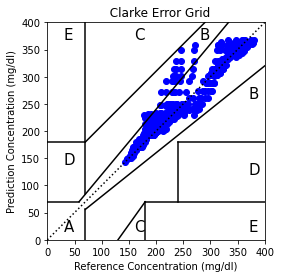

In [118]:
pred = predictions.reset_index()
clarke_error_grid(pred.predicted, pred.actual,' ')

### Further Development
Blood Glucose Forecasting based on the history of the patient has been an important research in the diabetes world. Many machine learning models have been generated that hold well and a literature review on the subject can show different ways to target this problem. A brief literature review was conducted before the start of this project. A time series model was finalized due to time constraints. The model development can be furthered by looking at different directions of enahncements as follows:

#### Additional Predictors 
Glucose is affected by too many varaibles. A few of them can be quantified like the carb intake and the insulin dose taken. There are many other factors like stress and emotions play a majopr factor too. While time series is a specialized model, it can be generalized by clustering users based on various characteristics like weight, age, diabetes type, insulin senitivity factor and generating model based on carbs, exercise, insuilin intake. 

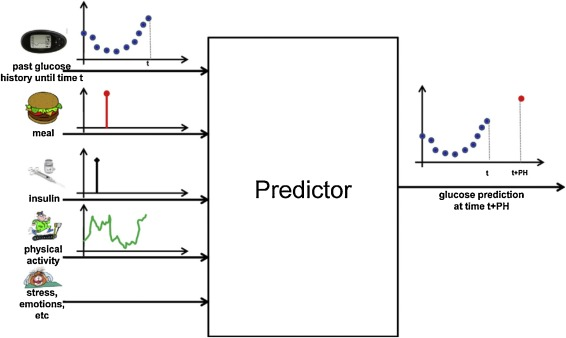


#### Time Series as Regression 
A lot of literature is present on this subject. By making sure that the collinearity can be avoided between the various features,the time series can be turned into a regression model 

#### Specializing the use case 
By understanding the use case, special models can be generated to address the particular problem. For example, if a user will go into hypoglycemia after carb intake and insulin dose. This requires analyzing onlt those events in the glucose datapoints

### Deployment 

Since the usecase described is to calibrate the glucose predictions every 30 mins, this will be cloud implementation with an api point ready to recieve the next entry of glucose data. This can be implemented using a pubsub technology. 
1. A function running in the backend can recieve the message by subscribing to the publisher
1. It can run the algorithm to make the prediction for the next 30 minutes based on the PtId(Patient ID)
1. Return the values and await the next incoming glucose entry 

### References
* Predicting Future Glucose Fluctuations Using Machine Learning and Wearable Sensor Data - https://diabetes.diabetesjournals.org/content/67/Supplement_1/738-P
* Data-driven modeling and prediction of blood glucose dynamics: Machine learning applications in type 1 diabetes - https://www.sciencedirect.com/science/article/pii/S0933365717306218
* Utility of Big Data in Predicting Short-Term Blood Glucose Levels in Type 1 Diabetes Mellitus Through Machine Learning Techniques - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6833040/
* A machine-learning approach to predict postprandial hypoglycemia - https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-019-0943-4